General info:                 
Size of the subset:           3519
Mean of the flux:             

2.125678e6
Variance of the flux:         209420.36
Variance of the errors:       0.002832904
Mean of the time differences: 0.026614859881868173
Lomb–Scargle periodogram:
The peak is at 0.2222989453247285.
The relevant estimate of the period is 4.498446893390457.


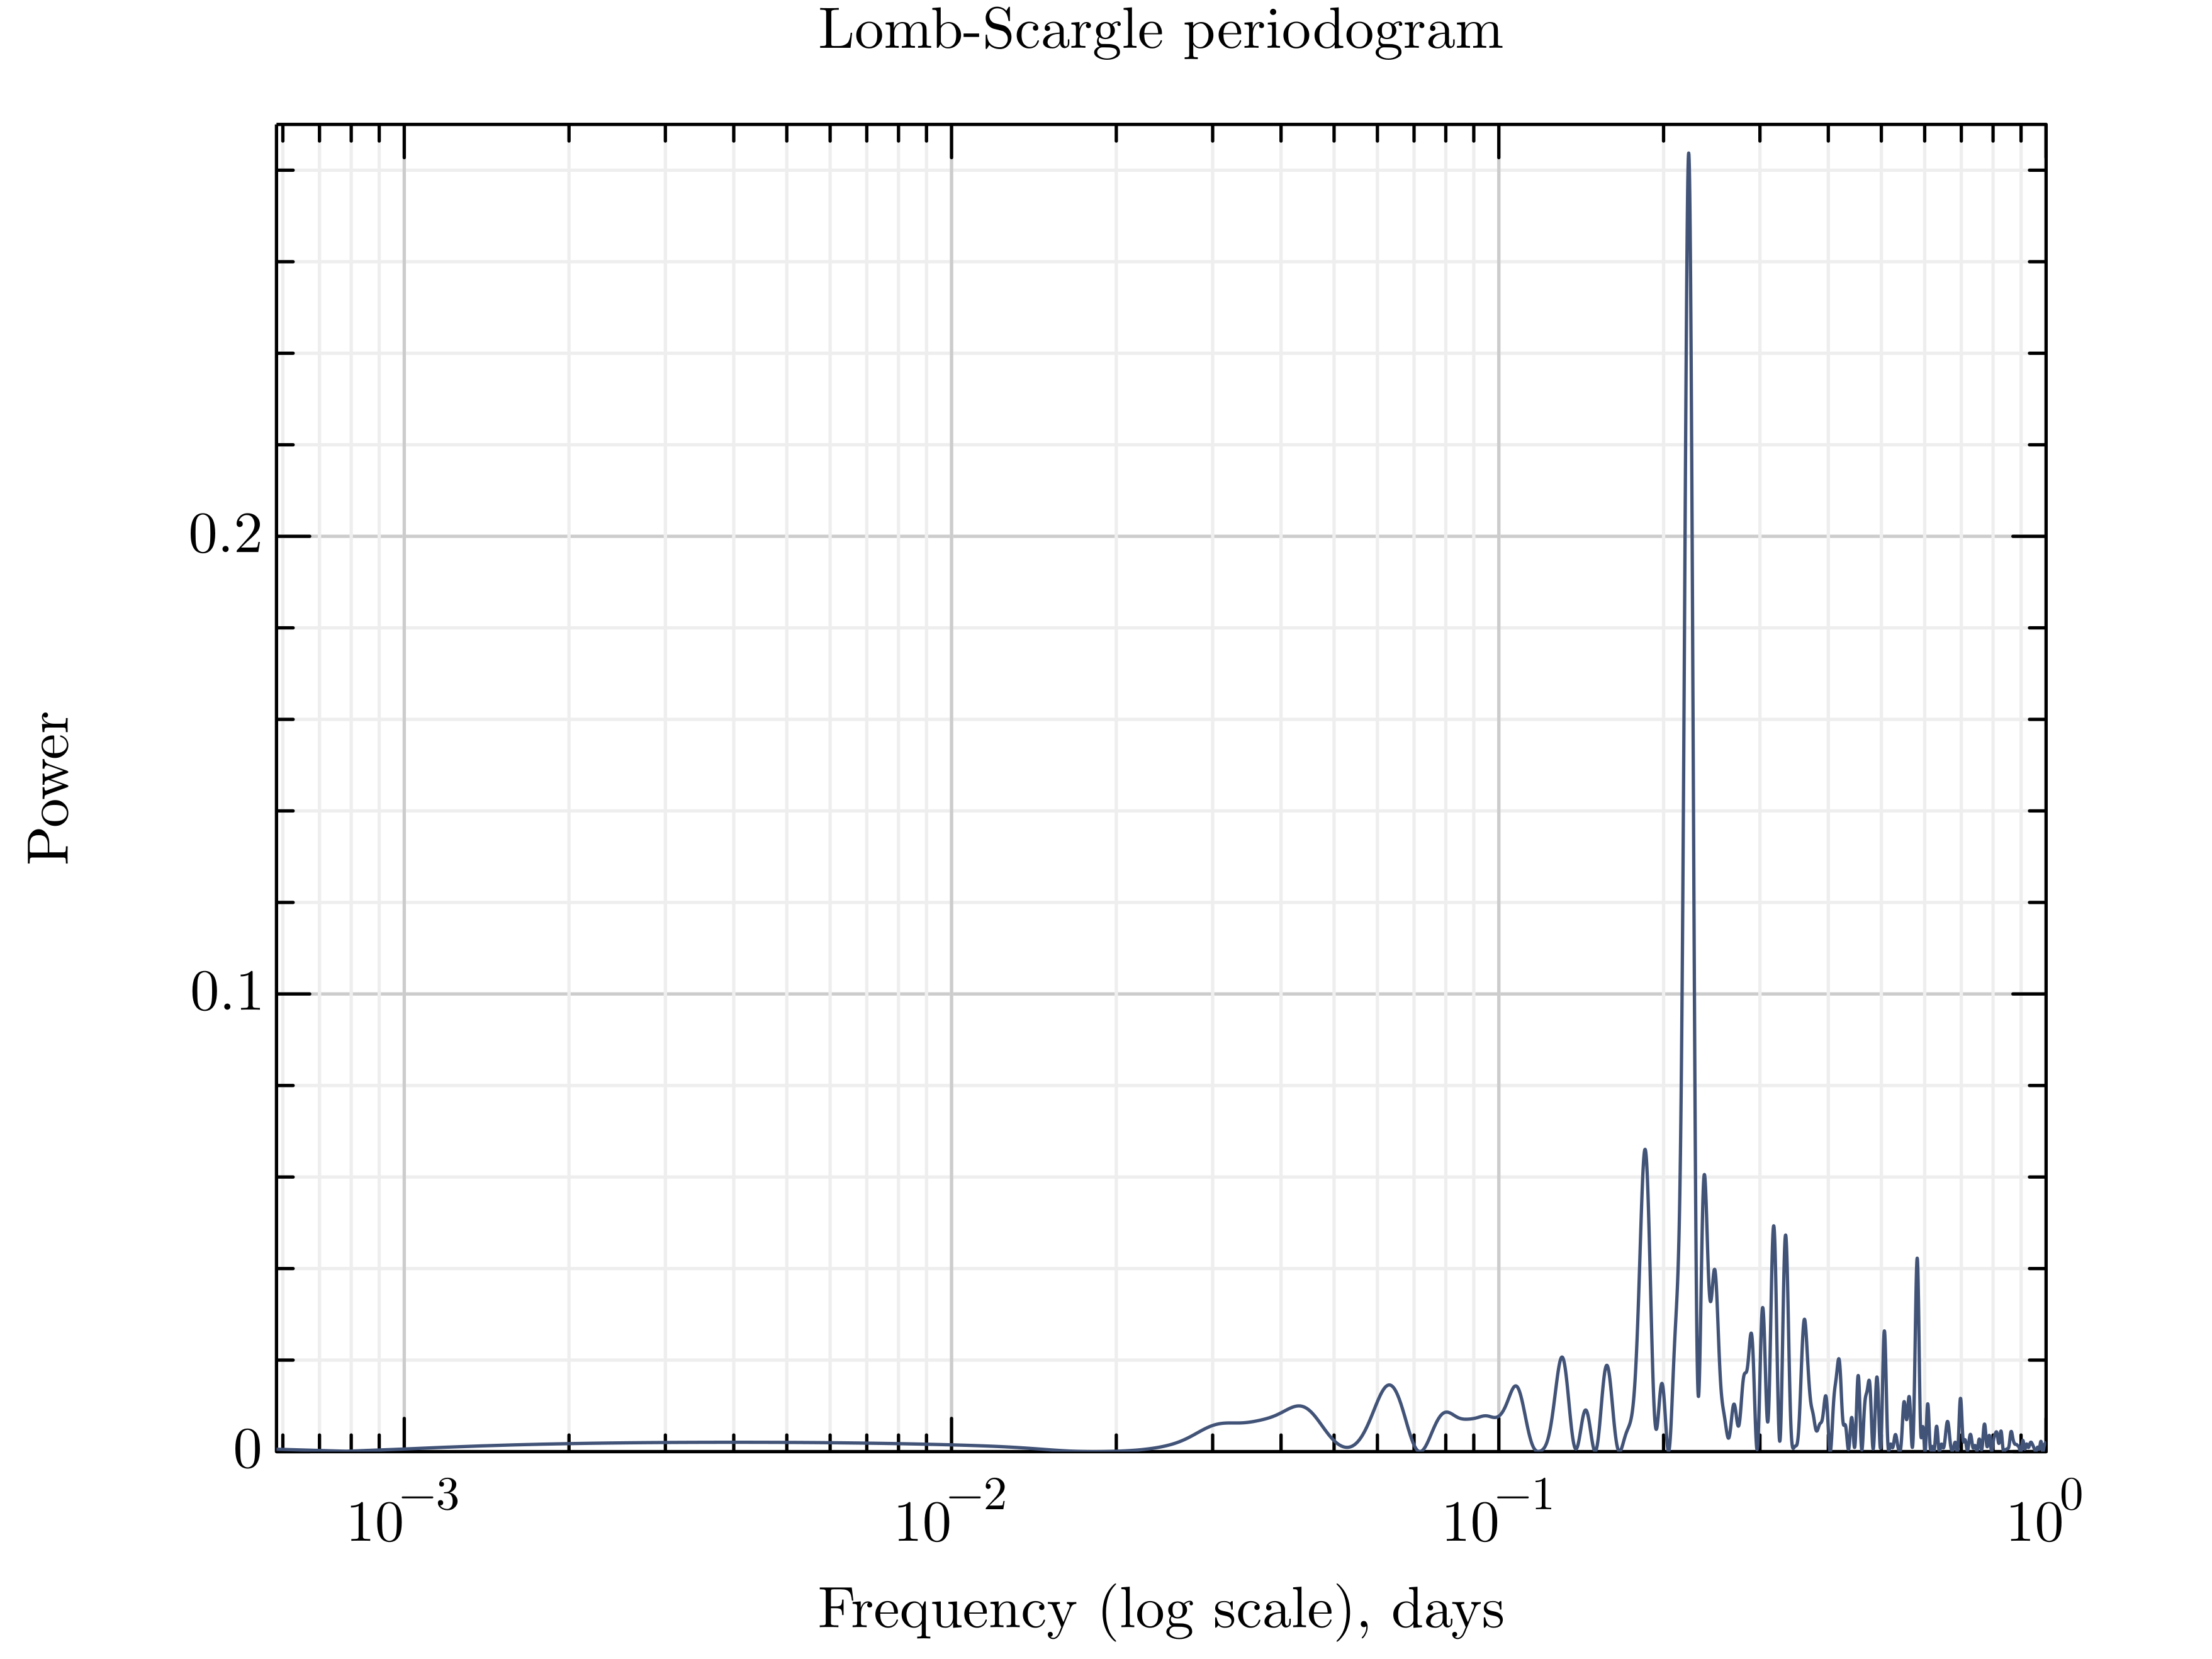

In [1]:
using NBInclude
@nbinclude("../KIC1430163.ipynb")

In [2]:
struct EQPKernel <: KernelFunctions.SimpleKernel
    A::Real
    l::Real
    P::Real
end

KernelFunctions.kappa(k::EQPKernel, τ::Real) = k.A * exp(-0.5 * τ^2 / k.l^2) * cos(2 * π * τ / k.P)
KernelFunctions.metric(k::EQPKernel) = KernelFunctions.Euclidean()

In [3]:
# Unpack a tuple of parameters
function unpack(θ)
    A = θ[1]
    l = θ[2]
    P = θ[3]
    μ = θ[4]
    σ²ₙ = θ[5]
    return A, l, P, μ, σ²ₙ
end

# Calculate the negative log marginal likelihood
function nlml(θ)
    A, l, P, μ, σ²ₙ = unpack(θ)
    k = EQPKernel(A, l, P)
    g = GP(μ, k, GPC())
    return -logpdf(g(t, σ²ₙ), f)
end
;

Negative log marginal likelihood: 21779.788561773057


GKS: invalid workstation type (Base.RefValue{String}("Base.RefValue{String}(\"svg\")"))


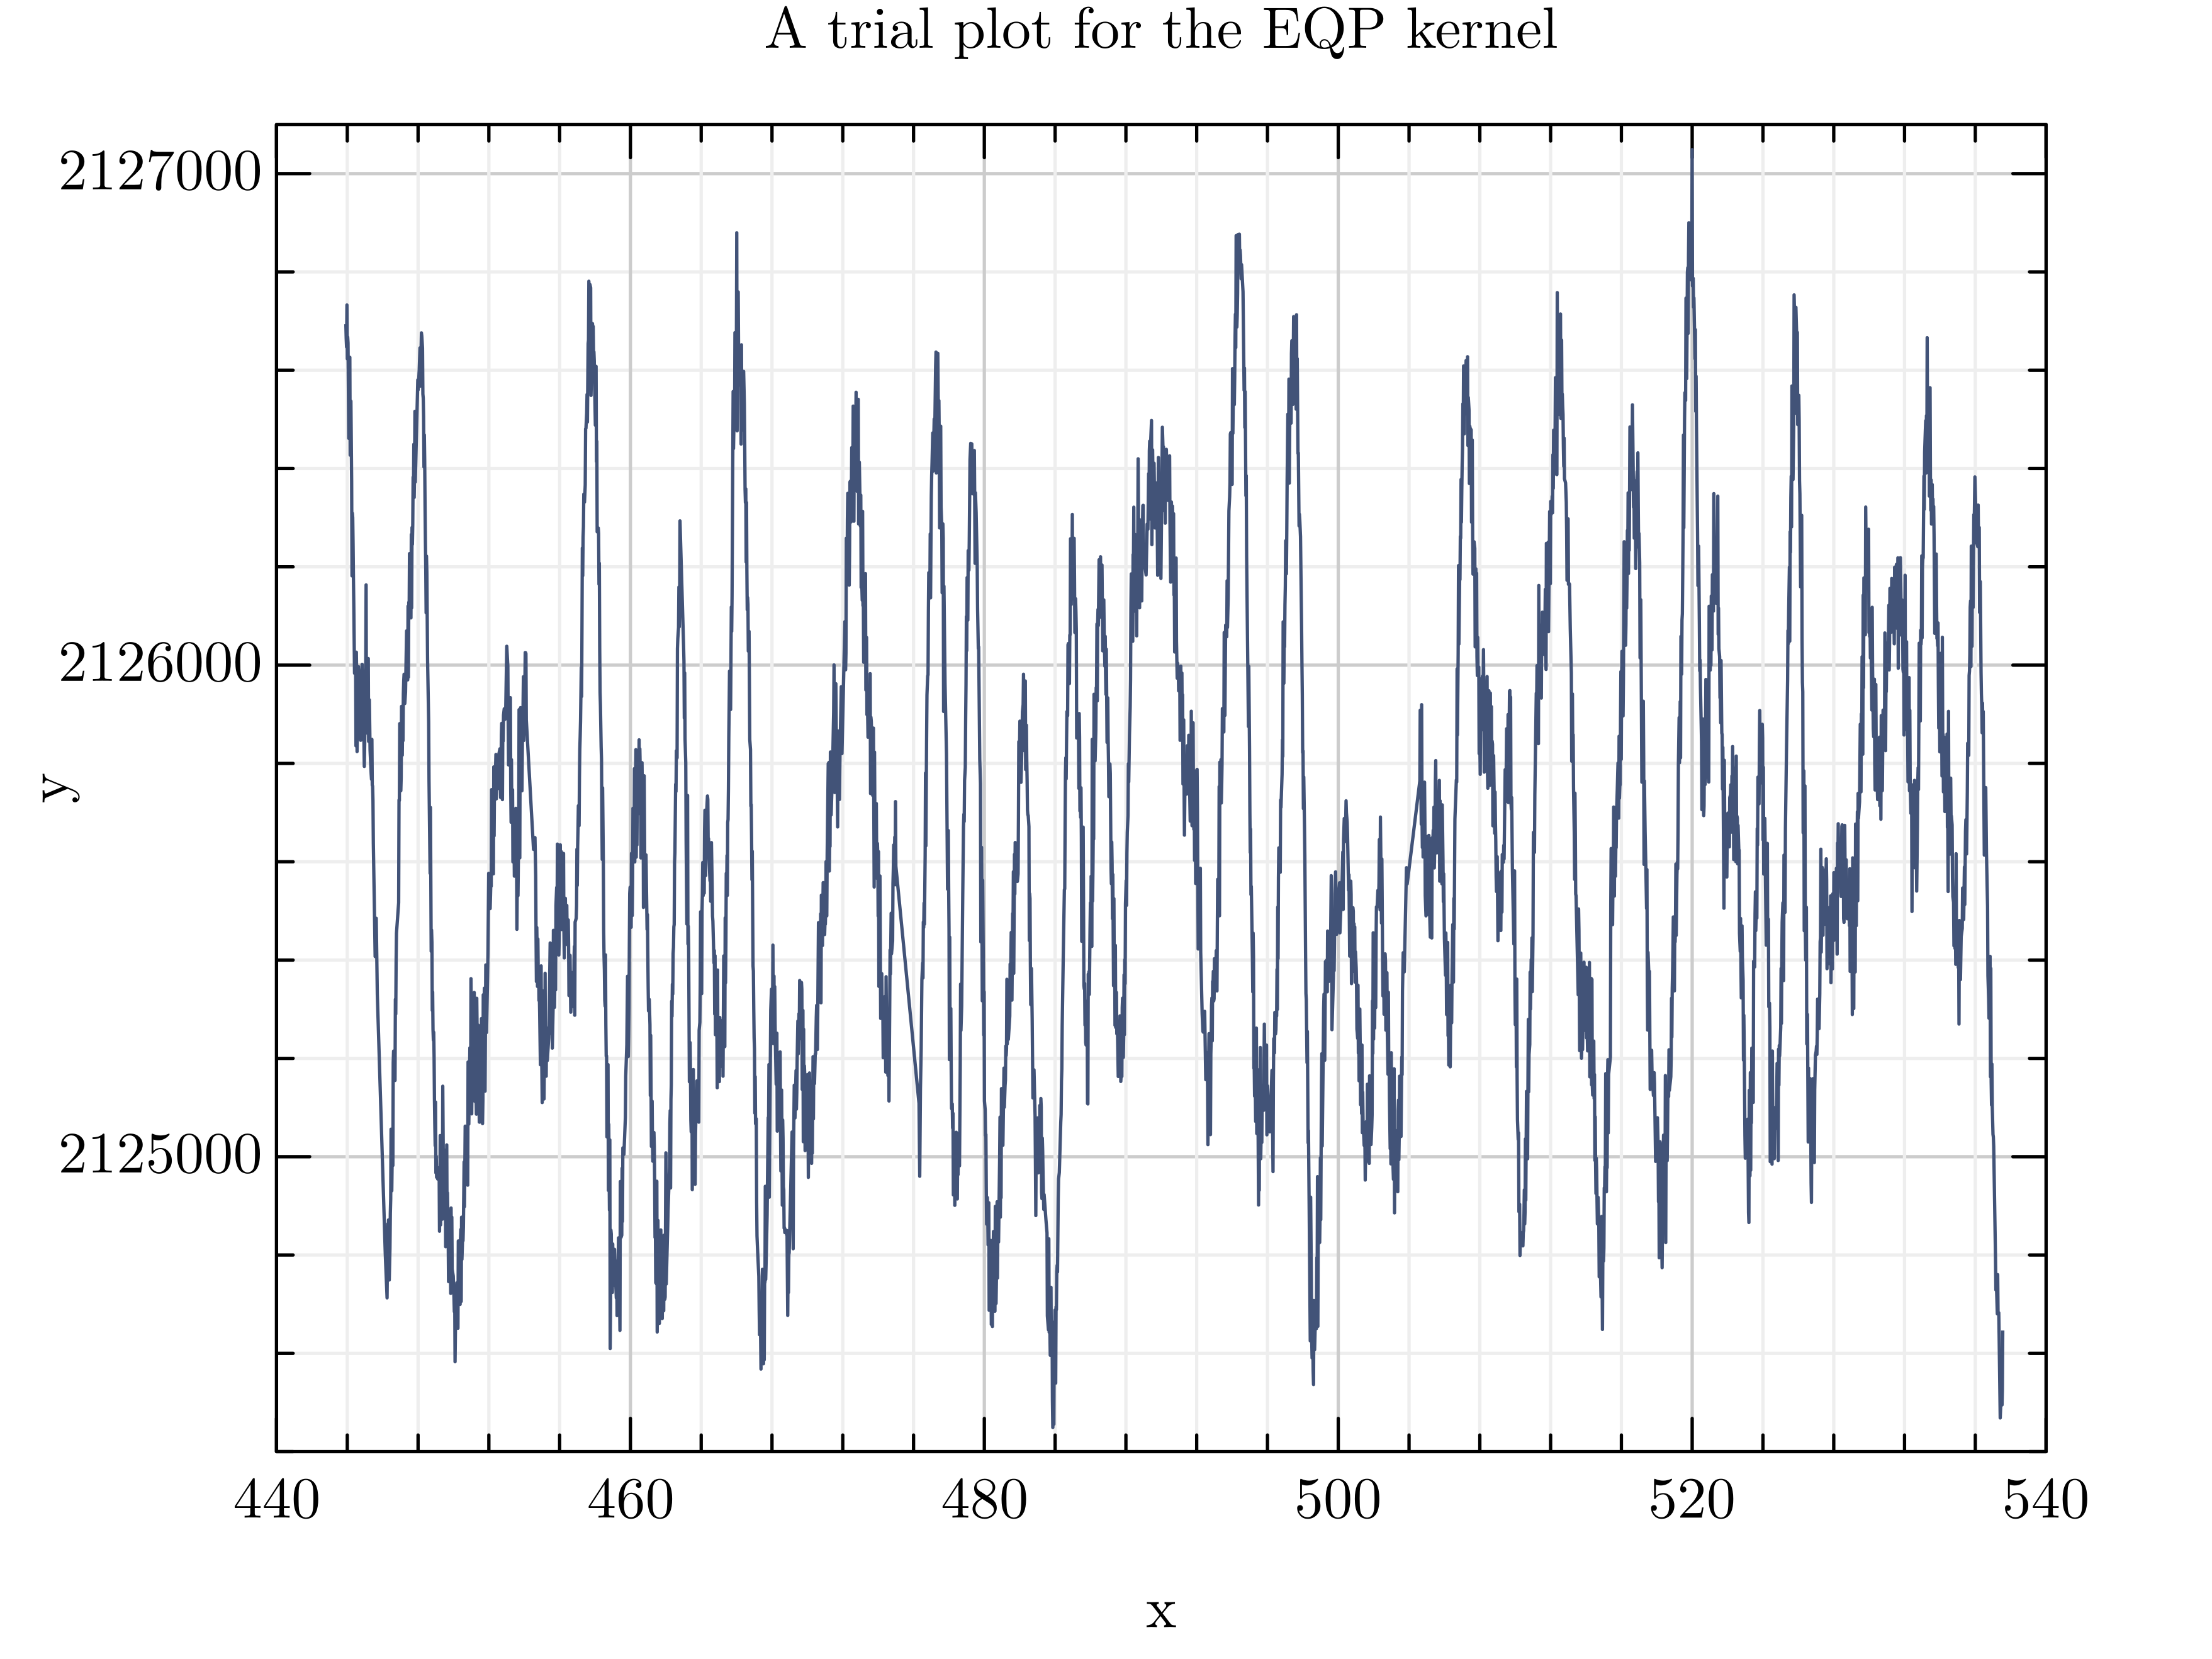

In [4]:
# Select the trial parameters
Aₜ = A₀
lₜ = 0.60
Pₜ = P₀
μₜ = μ₀
σ²ₙₜ = 5500

# Initialize the test kernel
k = EQPKernel(Aₜ, lₜ, Pₜ)

# Create a Gaussian process
g = GP(μₜ, k, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = t
y = rand(g(x, σ²ₙₜ))

plot(x, y; linecolor)

title("A trial plot for the EQP kernel")
xlabel("x")
ylabel("y")

θ = [Aₜ, lₜ, Pₜ, μₜ, σ²ₙₜ]
println("Negative log marginal likelihood: ", nlml(θ))

gcf()

In [ ]:
# Collect a parameters vector
θ₀ = [A₀, lₜ, P₀, μ₀, σ²ₙₜ]

# Define the lower and upper boundaries, respectively
θₗ = [209000.0, 0.45, 2.5, 2125650.0, 5400.0]
θᵤ = [210000.0, 0.7, 20.0, 2125750.0, 5800.0]

# Optimize the negative log marginal likelihood function
results = Optim.optimize(
    nlml,
    θ->Zygote.gradient(nlml, θ)[1],
    θₗ,
    θᵤ,
    θ₀,
    Fminbox(LBFGS()),
    Optim.Options(
        outer_iterations = 1,
        show_trace = true,
        extended_trace = true,
        store_trace = false,
    );
    inplace = false,
)

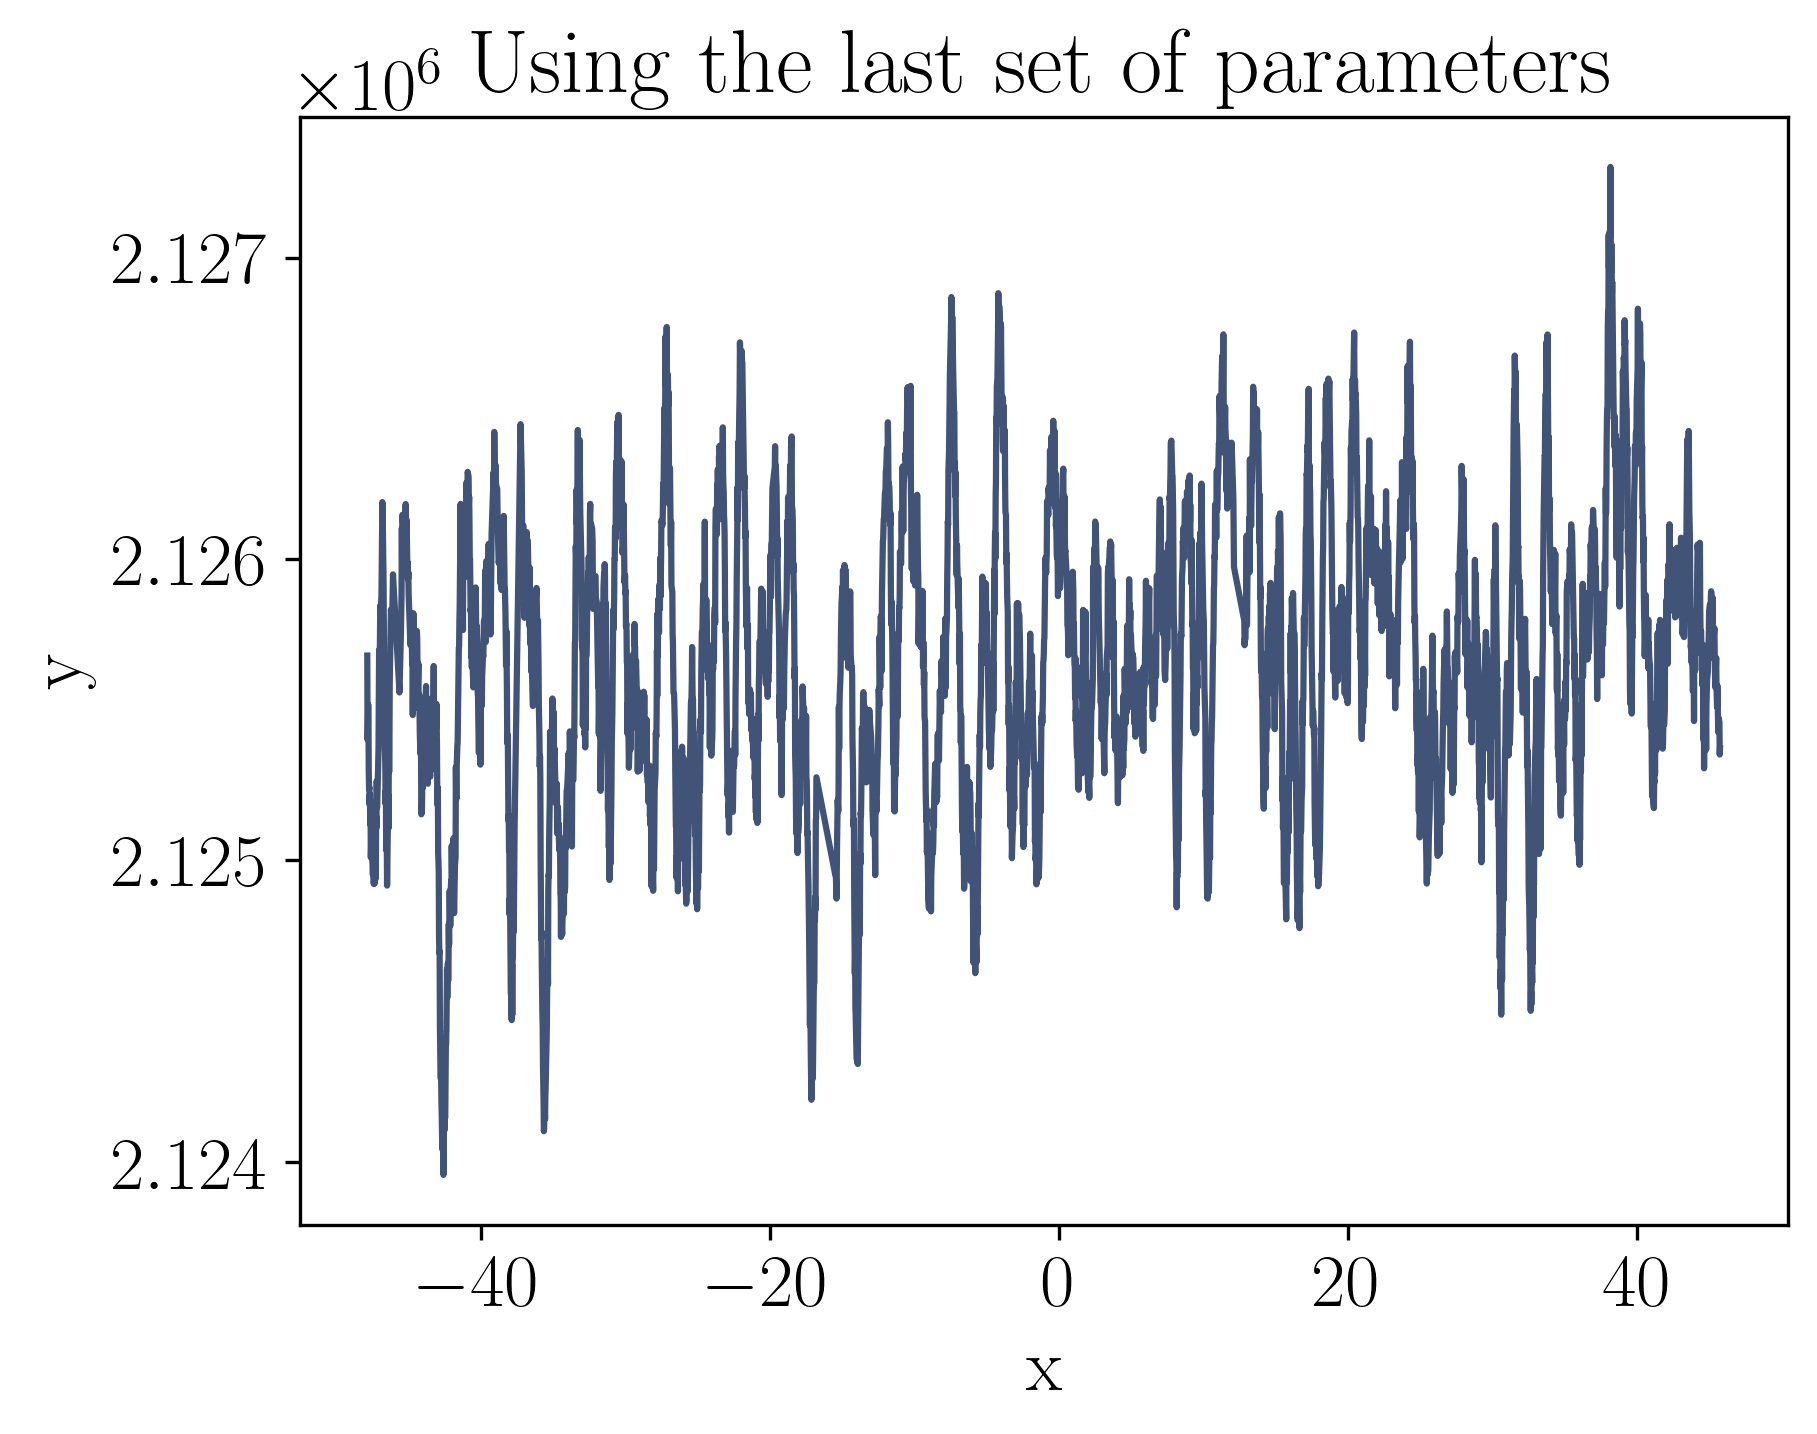

Negative log marginal likelihood: 21180.946475238452


In [8]:
# Take the last set of parameters
θₐ = results.minimizer

# Create a kernel
EQP = θₐ[1] * stretch(Stheno.EQ(), 1 / θₐ[2]^2) * Stheno.Cosine(θₐ[3] / 2)

# Create a Gaussian process
g = GP(θₐ[4], EQP, GPC())

# Take the values of one of the Gaussian process realizations
# on the time values of the original time series
x = t
y = rand(g(x, θₐ[5]))

close()
plot(x, y; color)

title(L"\textrm{Using the last set of parameters}")
xlabel(L"\textrm{x}")
ylabel(L"\textrm{y}")

println("Negative log marginal likelihood: ", nlml(θₐ))

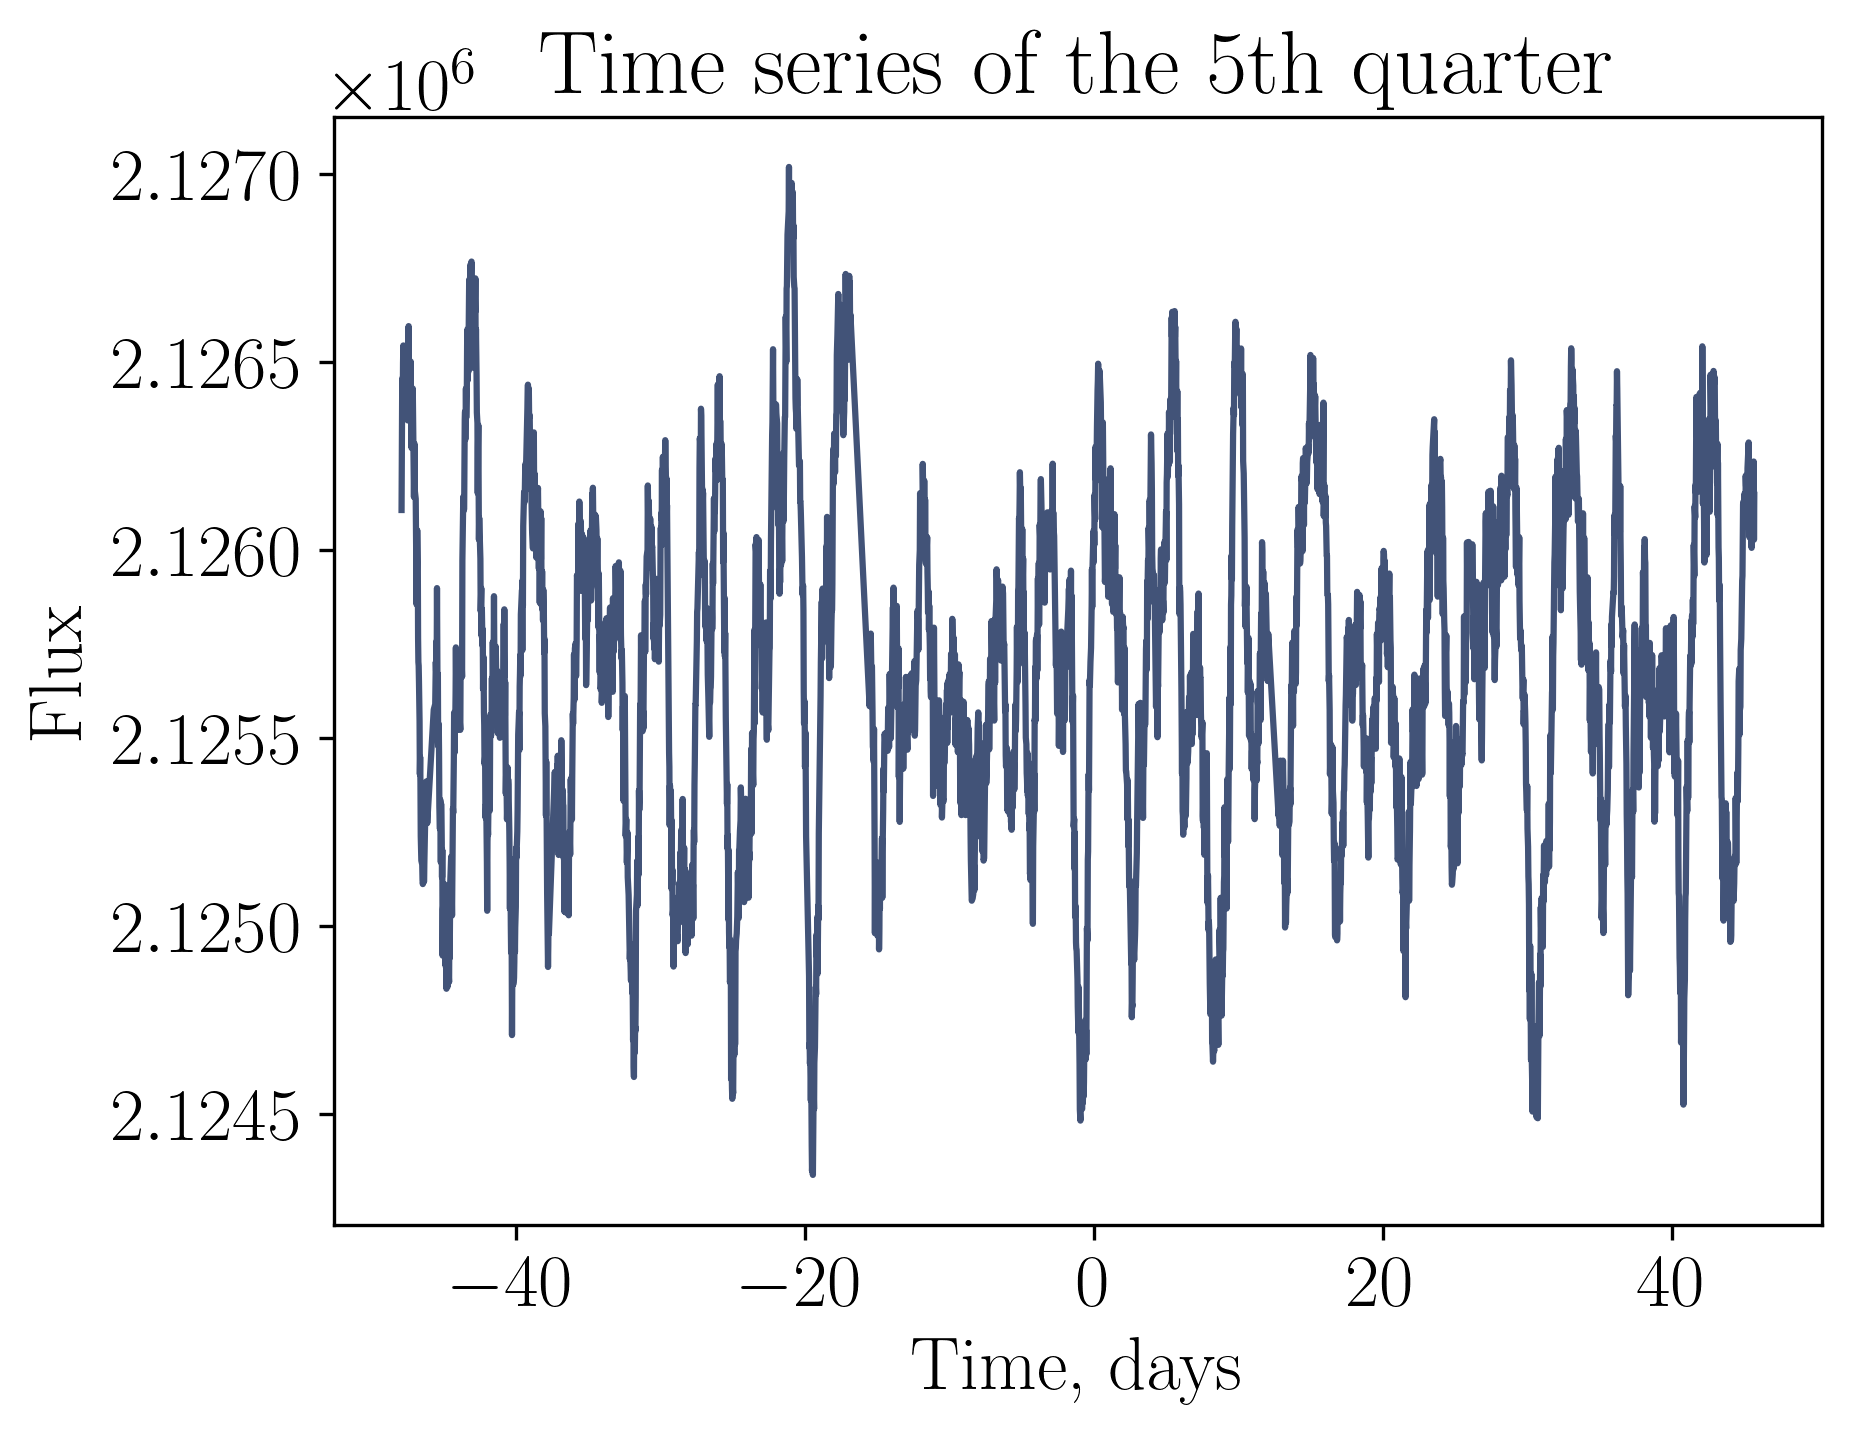

In [11]:
close()
plot(t, f, color)

xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")
title(L"\textrm{Time series of the 5th quarter}");

In [12]:
close()